# Install and imports

In [1]:
!pip install tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 6.1 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.3.1 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [2]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.0 MB/s eta 0:00:00


In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import load_model
from tensorflow.keras import losses
from tensorflow import keras
from sklearn.model_selection import train_test_split
import random
from PIL import Image

## Initialize random seed

In [4]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Upload images to predict tensile strength

In [5]:
# To access the data file from google drive
# If you have you files locally, plesea ignore this code block
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Path to images
image_path = "drive/MyDrive/IMGS-TESIS-NUEVAS/Imagenes catalogadas"
image_list = os.listdir(image_path)

## Functions

In [7]:
# Load images from path
def load_images(image_path, image_list):
  images = []
  labels = []
  for image_name in image_list:
    path = os.path.join(image_path, image_name)
    image = Image.open(path,)
    image = image.resize((250, 250))
    if image.mode != 'L':
      image = image.convert('L')

    images.append(image)
    if image_name.find("PVA_MCC_0") == 0:
      label = 33.18
      labels.append(label)
    if image_name.find("PVA_MCC_1") == 0:
      label = 18.87
      labels.append(label)
    if image_name.find("PVA_MCC_3") == 0:
      label = 18.74
      labels.append(label)
    if image_name.find("PVA_MCC_5") == 0:
      label = 14.23
      labels.append(label)

  images = np.array(images)
  images = images.reshape(-1, 250, 250, 1)
  images = tf.convert_to_tensor(images/250, dtype=tf.float32)
  labels = tf.convert_to_tensor(labels, dtype=tf.float32)
  return images, labels

# Custom accuracy metric
def custom_accuracy(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred) / K.maximum(K.abs(y_true), K.epsilon()), axis=-1)

# To include GrayScale to RGB conversion
@keras.utils.register_keras_serializable()
def preprocess_grayscale_to_rgb(input_image):
    return tf.image.grayscale_to_rgb(input_image)

# Predictions with a given model on input images
def preds(model, images, labels):

  loaded_model = tf.keras.models.load_model(model, custom_objects={'custom_accuracy': custom_accuracy})
  # Predictions
  predictions = loaded_model.predict(images)
  count = 0
  for i in range(len(predictions)):
      error = float(abs(predictions[i] - labels[i]) * 100 / labels[i])
      if error <= 5.00:
          count += 1

  print(f"Hits within 5% error: {count/len(predictions)}")

  count = 0
  for i in range(len(predictions)):
      error = float(abs(predictions[i] - labels[i]) * 100 / labels[i])
      if error <= 10.00:
          count += 1

  print(f"Hits within 10% error: {count/len(predictions)}")
  return predictions


In [8]:
images, labels = load_images(image_path, image_list)
predictions = preds('optimal_hyperparameters_transfer_learning_model.h5', images, labels)

2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step
Hits within 5% error: 0.5319148936170213
Hits within 10% error: 0.8085106382978723


# Prepare data

## Functions

In [9]:
def prepare_data(predictions, labels):
  preds = []
  for p in predictions:
    preds.append(p[0])
  result = list(zip(preds, labels))

  pva_0, pva_1, pva_2, pva_3 = [], [], [], []
  for i in range(47):
    if result[i][1] == 33.18:

      pva_0.append(result[i][0])
    if result[i][1] == 18.87:

      pva_1.append(result[i][0])
    if result[i][1] == 18.74:

      pva_2.append(result[i][0])
    if result[i][1] == 14.23:

      pva_3.append(result[i][0])
  return pva_0, pva_1, pva_2, pva_3

# Visualization



## Functions

In [10]:
def box_plot(pva_0, pva_1, pva_2, pva_3, title):
  data = [pva_0, pva_1, pva_2, pva_3]
  fig = plt.figure(figsize =(4, 1))
  ax = fig.add_axes([0, 1, 3, 5])

  bp = ax.boxplot(data)
  plt.title(title)
  plt.xticks([1, 2, 3, 4], ['PVA_MCC_0', 'PVA_MCC_1', 'PVA_MCC_3', 'PVA_MCC_5'])
  plt.grid()
  plt.ylabel('Resistencia a la tensión (N/mm^2)')
  plt.show()

## Boxplot Visualization

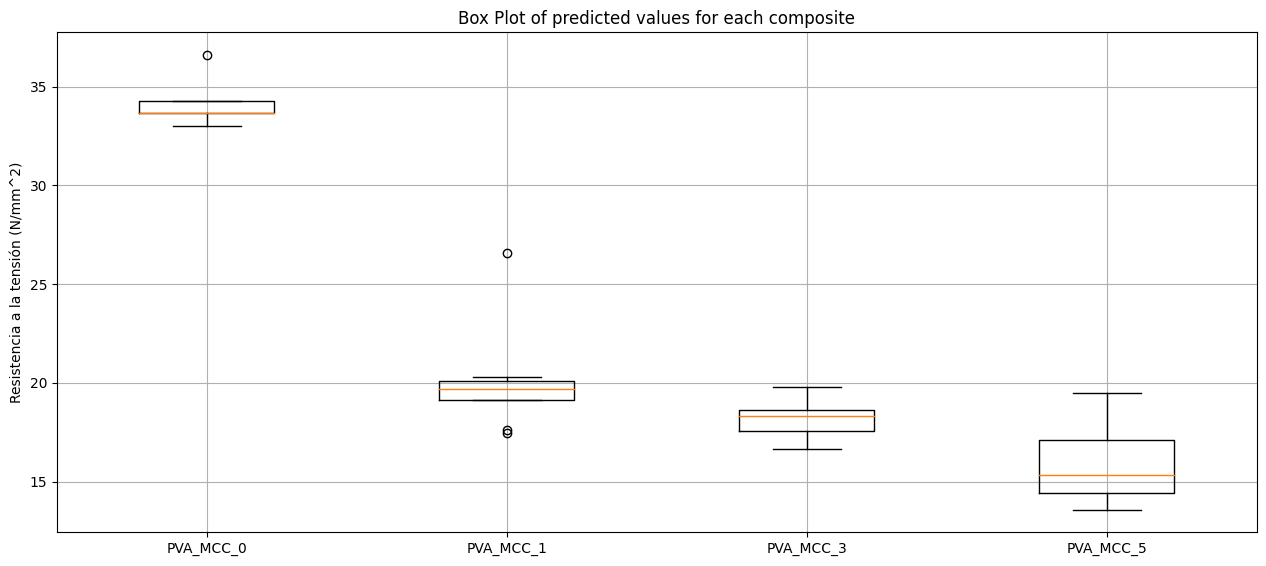

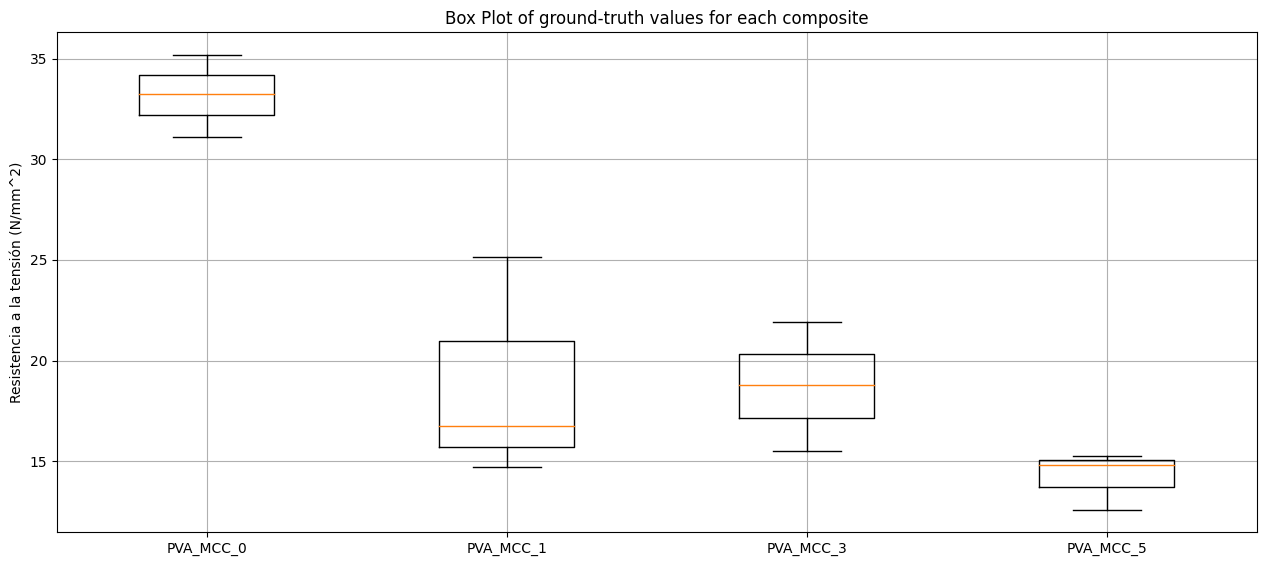

In [11]:
# Boxplot for tensile strength predicted values
pva_0, pva_1, pva_2, pva_3 = prepare_data(predictions, labels)
title_preds = 'Box Plot of predicted values for each composite'
box_plot(pva_0, pva_1, pva_2, pva_3, title_preds)

# Tensile strength boxplot for synthesized composites
pva_0_lab, pva_1_lab, pva_2_lab, pva_3_lab = [35.18, 31.12, 33.24], [25.16, 14.72, 16.74], [21.91, 15.53, 18.77], [14.82, 15.28, 12.6]
title_preds_lab = 'Box Plot of ground-truth values for each composite'
box_plot(pva_0_lab, pva_1_lab, pva_2_lab, pva_3_lab, title_preds_lab)